# 1) Import Packages

In [9]:
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import cv2 # pip3 install opencv-python-headless

import os
# print the dir for all the files within the dir
for dirname, dirnames, filenames in os.walk('./'):
    # Remove '.git' and 'compressed' from the list of subdirs to avoid walking into it
    if '.git' in dirnames:
        dirnames.remove('.git')
    if 'compressed' in dirnames:
        dirnames.remove('compressed')
    for filename in filenames:
        print(os.path.join(dirname, filename))

./README.md
./LICENSE
./scitkit_k_NN_image_compression.py
./README.md~
./scitkit_k_NN_image_compression.ipynb
./images/cool_pizza.png
./images/DALLE_image.png
./images/pexels_steve_johnson.jpg


# 2) Import and process image
- Define a function to store the dimenions and number of colors per pixel
- Convert the image to RGB since OpenCV uses BGR by default
- Define number of clusters and run the model

In [10]:
# dimensions of the image in pixels and number of colors
def image_dimensions(image):
    height = image.shape[0]
    width = image.shape[1]
    c = image.shape[2]
    print(f'Height = {height}\nWidth = {width}\nNumber of colors per pixel = {c}')
    return height, width, c

Height = 1024
Width = 1024
Number of colors per pixel = 3


(-0.5, 1023.5, 1023.5, -0.5)

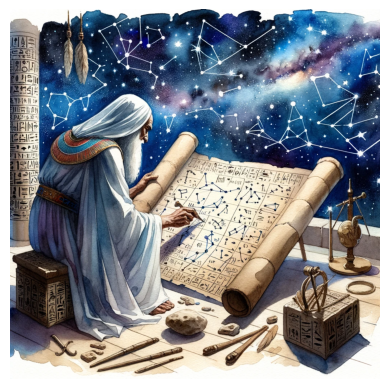

In [28]:
# Load the image and reshape it to a 2D array of pixels
image_path = './images/DALLE_image.png'
original_image = cv2.imread(image_path)

# save image name
base_name = os.path.basename(image_path)
image_name_no_ext = os.path.splitext(base_name)[0]
image_ext = os.path.splitext(base_name)[-1]

# convert to RGB (BGR is default in openCV2)
image_RGB = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# image dimensions
h, w, c =image_dimensions(image_RGB)

plt.imshow(image_RGB)
plt.axis('off')

In [29]:
# flatten to 1D array
flatten_pixels = image_RGB.reshape((-1, 3))

# to cluster around the common colors, first get the frequency for unique pixels and get their frequency and weights
pixel_freq = Counter(map(tuple, flatten_pixels))
unique_pixels = np.array(list(pixel_freq.keys()))
weights = np.array(list(pixel_freq.values()))

In [30]:
# how many clusters?
k_clusters = 5

# Create a KMeans instance with k_clusters 
k_Means = KMeans(n_clusters=k_clusters, init='k-means++', n_init=20, max_iter=200)

# Fit weighted k_means around the most common pixels
k_Means.fit(unique_pixels, sample_weight=weights)

# fetch the centroids and labels
cluster_centers = k_Means.cluster_centers_
compressed_labels = k_Means.labels_

# 3) Inference
- What are the color clusters found?
- Sort them, ascending, by the intensity of the red pixels.
- Combine the palette along the image

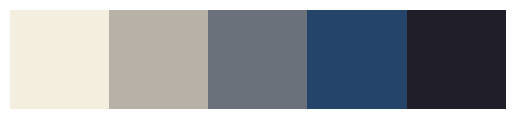

In [31]:

# Get clusters and flatten to get palette
palette = np.uint8(cluster_centers).reshape(-1, 3)

# Sort ascending by the Red channel (index 0)
sorted_palette = palette[np.argsort(-palette[:, 0])]

# Reshape it back to the original dimensions
sorted_palette = sorted_palette.reshape(1, k_clusters, c)

#palette_RGB = cv2.cvtColor(sorted_palette, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(sorted_palette)

In [32]:
# Get the labels for the original flattened pixel array
original_labels = k_Means.predict(flatten_pixels)

# Map each original pixel to its corresponding centroid
compressed_pixels = cluster_centers[original_labels]

# Reshape to the original image shape
compressed_image = compressed_pixels.reshape(image_RGB.shape).astype(np.uint8)

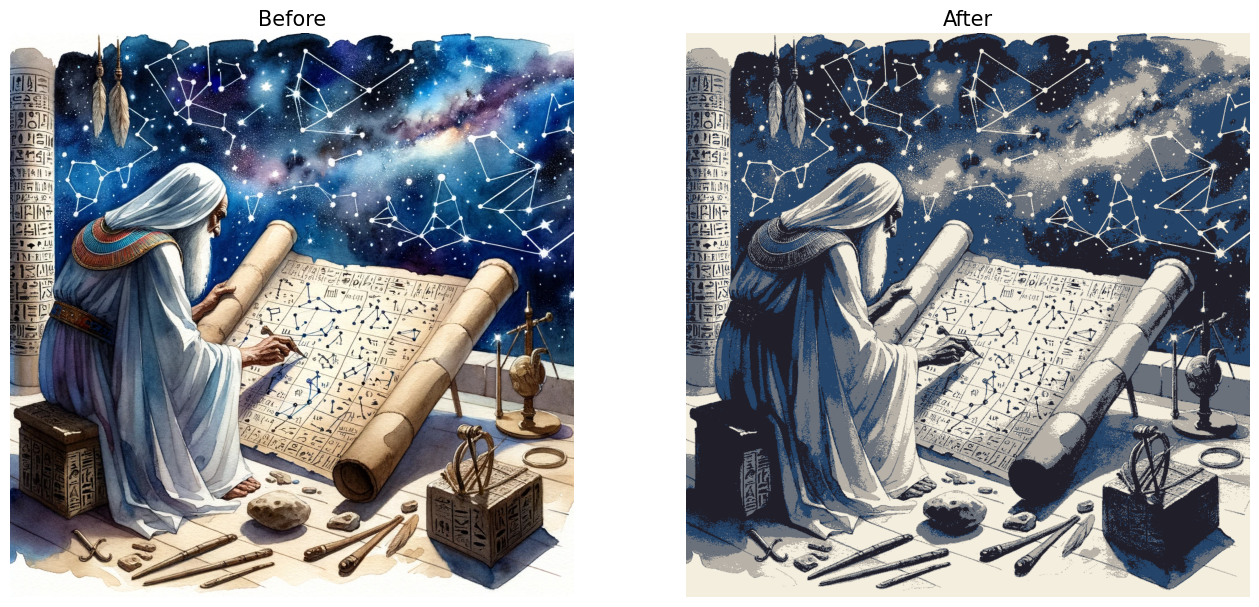

In [33]:
# width and height of color bars are determined based on the resolution and number of clusters
color_bar_height = h // k_clusters
color_bar_width = w // 20 # 5% of the original image's width
dpi = 70
fig, axes = plt.subplots(1,2,figsize=(16,9))
#plt.imshow(compressed_image)

for ax, img, j in zip(axes, [image_RGB, compressed_image], ['Before', 'After']):
    ax.imshow(img)
    ax.set_title(j, fontsize=15)
    ax.axis('off')

#plt.savefig('compressed_'+image_name_no_ext+image_ext, bbox_inches='tight', pad_inches=0)

(-0.5, 1074.5, 1023.5, -0.5)

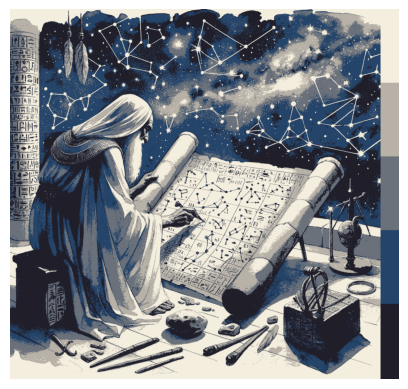

In [34]:
# Horizontal stack
# Create a color bar image
color_bar = np.zeros((h, color_bar_width, 3), dtype=np.uint8)

# Fill the color bar with the sorted_palette colors
for idx, color in enumerate(sorted_palette[0]):
    start_y = idx * color_bar_height
    end_y = (idx + 1) * color_bar_height
    color_bar[start_y:end_y, :] = color

# Fill any remaining space with the last color
if end_y < h:
    color_bar[end_y:, :] = sorted_palette[0][-1]
    
# Concatenate the compressed image and the color bar
concatenated_image = np.hstack((compressed_image, color_bar))

# Save the concatenated image
#cv2.imshow('Abstract', concatenated_image)
cv2.imwrite('compressed_' + image_name_no_ext + image_ext, cv2.cvtColor(concatenated_image, cv2.COLOR_RGB2BGR))
plt.imshow(concatenated_image)
plt.axis('off')